## Artigo Original: https://arxiv.org/abs/2306.17624

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/MyDrive

/content/drive/MyDrive


In [3]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F

import torch.utils.data
import math


class LayerNorm(nn.Module):
    """
    layer normalization
    Simple layer norm object optionally used with the convolutional encoder.
    """

    def __init__(self, feature_dim, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones((feature_dim,)))
        self.register_parameter("gamma", self.gamma)
        self.beta = nn.Parameter(torch.zeros((feature_dim,)))
        self.register_parameter("beta", self.beta)
        self.eps = eps

    def forward(self, x):
        # x: [batch_size, embed_dim]
        # normalize for each embedding
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # output shape is the same as x
        # Type not match for self.gamma and self.beta??????????????????????
        # output: [batch_size, embed_dim]
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


def get_activation_function(activation, context_str):
    if activation == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.2)
    elif activation == "relu":
        return nn.ReLU()
    elif activation == "sigmoid":
        return nn.Sigmoid()
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'gelu':
        return nn.GELU()
    else:
        raise Exception("{} activation not recognized.".format(context_str))


class SingleFeedForwardNN(nn.Module):
    """
        Creates a single layer fully connected feed forward neural network.
        this will use non-linearity, layer normalization, dropout
        this is for the hidden layer, not the last layer of the feed forard NN
    """

    def __init__(self, input_dim,
                 output_dim,
                 dropout_rate=None,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=''):
        '''

        Args:
            input_dim (int32): the input embedding dim
            output_dim (int32): dimension of the output of the network.
            dropout_rate (scalar tensor or float): Dropout keep prob.
            activation (string): tanh or relu or leakyrelu or sigmoid
            use_layernormalize (bool): do layer normalization or not
            skip_connection (bool): do skip connection or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(SingleFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        if dropout_rate is not None:
            self.dropout = nn.Dropout(p=dropout_rate)
        else:
            self.dropout = None

        self.act = get_activation_function(activation, context_str)

        if use_layernormalize:
            # the layer normalization is only used in the hidden layer, not the last layer
            self.layernorm = nn.LayerNorm(self.output_dim)
        else:
            self.layernorm = None

        # the skip connection is only possible, if the input and out dimention is the same
        if self.input_dim == self.output_dim:
            self.skip_connection = skip_connection
        else:
            self.skip_connection = False

        self.linear = nn.Linear(self.input_dim, self.output_dim)
        nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size,..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        # Linear layer
        output = self.linear(input_tensor)
        # non-linearity
        output = self.act(output)
        # dropout
        if self.dropout is not None:
            output = self.dropout(output)

        # skip connection
        if self.skip_connection:
            output = output + input_tensor

        # layer normalization
        if self.layernorm is not None:
            output = self.layernorm(output)

        return output


class MultiLayerFeedForwardNN(nn.Module):
    """
        Creates a fully connected feed forward neural network.
        N fully connected feed forward NN, each hidden layer will use non-linearity, layer normalization, dropout
        The last layer do not have any of these
    """

    def __init__(self, input_dim,
                 output_dim,
                 num_hidden_layers=0,
                 dropout_rate=None,
                 hidden_dim=-1,
                 activation="sigmoid",
                 use_layernormalize=False,
                 skip_connection=False,
                 context_str=None):
        '''

        Args:
            input_dim (int32): the input embedding dim
            num_hidden_layers (int32): number of hidden layers in the network, set to 0 for a linear network.
            output_dim (int32): dimension of the output of the network.
            dropout (scalar tensor or float): Dropout keep prob.
            hidden_dim (int32): size of the hidden layers
            activation (string): tanh or relu
            use_layernormalize (bool): do layer normalization or not
            context_str (string): indicate which spatial relation encoder is using the current FFN

        '''
        super(MultiLayerFeedForwardNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_hidden_layers = num_hidden_layers
        self.dropout_rate = dropout_rate
        self.hidden_dim = hidden_dim
        self.activation = activation
        self.use_layernormalize = use_layernormalize
        self.skip_connection = skip_connection
        self.context_str = context_str

        self.layers = nn.ModuleList()
        if self.num_hidden_layers <= 0:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))
        else:
            self.layers.append(SingleFeedForwardNN(input_dim=self.input_dim,
                                                   output_dim=self.hidden_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=self.use_layernormalize,
                                                   skip_connection=self.skip_connection,
                                                   context_str=self.context_str))

            for i in range(self.num_hidden_layers - 1):
                self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                       output_dim=self.hidden_dim,
                                                       dropout_rate=self.dropout_rate,
                                                       activation=self.activation,
                                                       use_layernormalize=self.use_layernormalize,
                                                       skip_connection=self.skip_connection,
                                                       context_str=self.context_str))

            self.layers.append(SingleFeedForwardNN(input_dim=self.hidden_dim,
                                                   output_dim=self.output_dim,
                                                   dropout_rate=self.dropout_rate,
                                                   activation=self.activation,
                                                   use_layernormalize=False,
                                                   skip_connection=False,
                                                   context_str=self.context_str))

    def forward(self, input_tensor):
        '''
        Args:
            input_tensor: shape [batch_size, ..., input_dim]
        Returns:
            tensor of shape [batch_size, ..., output_dim]
            note there is no non-linearity applied to the output.

        Raises:
            Exception: If given activation or normalizer not supported.
        '''
        assert input_tensor.size()[-1] == self.input_dim
        output = input_tensor
        for i in range(len(self.layers)):
            output = self.layers[i](output)

        return output

In [5]:
import torch
import torch.nn as nn
import numpy as np

class SpherePositionEncoder(nn.Module):

    def __init__(self, min_scale=1, max_scale=1000, num_scales=16, num_centroids=128, device='cuda'):
        super().__init__()
        self.device = device
        self.num_scales = num_scales
        self.num_centroids = num_centroids

        scales = torch.logspace(np.log10(min_scale), np.log10(max_scale), num_scales)
        self.register_buffer('scales', scales)

        centroids = torch.randn(num_centroids, 3)
        centroids = torch.nn.functional.normalize(centroids, dim=-1)
        self.register_buffer('centroids', centroids)

    def forward(self, coords):
        if not torch.is_tensor(coords):
            coords = torch.tensor(coords, dtype=torch.float32).to(self.device)
        else:
            coords = coords.float().to(self.device)

        lat = coords[..., 0]
        lon = coords[..., 1]
        lat_rad = torch.deg2rad(lat)
        lon_rad = torch.deg2rad(lon)

        x = torch.cos(lat_rad) * torch.cos(lon_rad)
        y = torch.cos(lat_rad) * torch.sin(lon_rad)
        z = torch.sin(lat_rad)

        input_vec = torch.stack([x, y, z], dim=-1)

        dot_product = torch.matmul(input_vec, self.centroids.t())

        distance = 1.0 - dot_product
        weighted_dist = distance.unsqueeze(-1) * self.scales.view(1, 1, -1)

        rbf_feat = torch.exp(-weighted_dist)

        emb = rbf_feat.flatten(1)

        return emb

class SphereLocationEncoder(nn.Module):
    def __init__(
        self,
        spa_embed_dim=64,
        num_scales=16,
        min_scale=1,
        max_scale=1000,
        num_centroids=128,
        ffn_hidden_dim=256,
        device="cuda",
        extent=None, interval=None, ffn_num_hidden_layers=1, ffn_dropout_rate=0.5, ffn_act="relu", ffn_use_layernormalize=True, ffn_skip_connection=True
    ):
        super().__init__()
        self.device = device

        self.position_encoder = SpherePositionEncoder(
            min_scale=min_scale,
            max_scale=max_scale,
            num_scales=num_scales,
            num_centroids=num_centroids,
            device=device
        )

        input_dim = num_centroids * num_scales

        self.input_projector = nn.Linear(input_dim, ffn_hidden_dim)

        self.ffn = MultiLayerFeedForwardNN(
            input_dim=ffn_hidden_dim,
            output_dim=spa_embed_dim,
            num_hidden_layers=ffn_num_hidden_layers,
            dropout_rate=ffn_dropout_rate,
            hidden_dim=ffn_hidden_dim,
            activation=ffn_act,
            use_layernormalize=ffn_use_layernormalize,
            skip_connection=ffn_skip_connection,
            context_str="Sphere2Vec"
        )

    def forward(self, coords):
        feat = self.position_encoder(coords)
        feat = self.input_projector(feat)
        out = self.ffn(feat)
        return out

In [6]:
import pandas as pd
ESTADO = 'Alaska'
checkins = pd.read_csv(f'/content/drive/MyDrive/Checkins_MTLPoi/separated/checkins_{ESTADO.title()}.csv')[['latitude', 'longitude', 'category','placeid']]
coords = np.stack([checkins['latitude'], checkins['longitude']], axis=1)

categories = checkins[['category']].values
placeid = checkins[['placeid']].values

In [7]:
class SphereLocationContrastiveModel(nn.Module):
    def __init__(self, embed_dim=64):
        super().__init__()
        self.encoder = SphereLocationEncoder(
            spa_embed_dim=128,
            num_scales=32,
            min_scale=10,
            max_scale=1e7,
            num_centroids=256,
            ffn_hidden_dim=512,
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        self.projector = nn.Linear(128, embed_dim)

    def forward(self, coords):
        z = self.encoder(coords)
        z = self.projector(z)
        return torch.nn.functional.normalize(z, dim=-1)

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ContrastiveSpatialDataset(Dataset):
    def __init__(self, coords, pos_radius=0.01):
        """
        Args:
            coords: Array numpy ou Tensor [N, 2] com todas as coordenadas (Lat, Lon).
            pos_radius: Raio (em graus) para considerar um ponto como "vizinho" (positivo).
                        0.01 graus é aprox 1.1km.
        """
        self.coords = coords
        self.num_points = len(coords)
        self.pos_radius = pos_radius

    def __len__(self):
        return self.num_points

    def __getitem__(self, idx):
        coord_i = self.coords[idx]

        if np.random.random() > 0.5:
            label = 1.0

            noise = np.random.normal(0, self.pos_radius, size=2)
            coord_j = coord_i + noise

        else:
            label = 0.0

            rand_idx = np.random.randint(0, self.num_points)
            coord_j = self.coords[rand_idx]

        return (
            torch.tensor(coord_i, dtype=torch.float32),
            torch.tensor(coord_j, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32)
        )

In [9]:
dataset = ContrastiveSpatialDataset(coords, pos_radius=0.01)

loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

print(f"Total de batches por época: {len(loader)}")

sample_i, sample_j, sample_lbl = next(iter(loader))
print("\nExemplo de saída do Loader:")
print(f"Coord A (Shape): {sample_i.shape}")
print(f"Coord B (Shape): {sample_j.shape}")
print(f"Labels (Exemplo): {sample_lbl[:5]}")

Total de batches por época: 425

Exemplo de saída do Loader:
Coord A (Shape): torch.Size([64, 2])
Coord B (Shape): torch.Size([64, 2])
Labels (Exemplo): tensor([1., 1., 0., 0., 1.])


In [10]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [11]:
!pip install "sympy==1.12"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.9.0+cpu requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


In [ ]:
device = 'cpu'

model = SphereLocationContrastiveModel(
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def contrastive_bce(z_i, z_j, label, tau=0.1):
    sim = F.cosine_similarity(z_i, z_j)
    logits = sim / tau
    targets = label.float().to(z_i.device)
    return F.binary_cross_entropy_with_logits(logits, targets)


for epoch in range(50):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for coord_i, coord_j, label in loader:

        ci = coord_i.float().to(device)
        cj = coord_j.float().to(device)

        z_i = model(ci)
        z_j = model(cj)

        loss = contrastive_bce(z_i, z_j, label, tau=0.15)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    avg_loss = total_loss / max(n_batches, 1)
    print(f"Epoch {epoch+1:02d}: Loss = {avg_loss:.4f}")



Epoch 01: Loss = 0.8511


In [ ]:
loc_embeds = model(torch.Tensor(coords))

loc_embeds

tensor([[-0.1515, -0.1102,  0.0857,  ..., -0.0511,  0.0908, -0.0803],
        [-0.1904, -0.2057,  0.1168,  ..., -0.1029,  0.1393,  0.0449],
        [ 0.0844, -0.1705,  0.1772,  ..., -0.0053, -0.0771, -0.1260],
        ...,
        [ 0.0227, -0.0100, -0.0050,  ..., -0.2065, -0.1844, -0.0041],
        [ 0.2017,  0.1452,  0.0037,  ..., -0.1029, -0.0882, -0.1314],
        [ 0.0351,  0.0717, -0.0788,  ...,  0.0588, -0.0490, -0.0594]],
       grad_fn=<DivBackward0>)

In [ ]:
loc_embeds = loc_embeds.detach().numpy()

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
folder_path = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/sphere2vec/"
if not os.path.exists(folder_path):
  os.makedirs(folder_path)

emb_np = loc_embeds
n_embeds = emb_np.shape[1]
embed_cols = [f"{i}" for i in range(n_embeds)]

placeid_arr   = np.asarray(placeid).reshape(-1)
category_arr  = np.asarray(categories).reshape(-1)

if emb_np.shape[0] != len(placeid_arr):
    raise ValueError(f"loc_embeds tem {emb_np.shape[0]} linhas, "
                     f"mas placeid tem {len(placeid_arr)} elementos.")

df_location_embeddings = pd.DataFrame(emb_np, columns=embed_cols)
df_location_embeddings.insert(0, "placeid", placeid_arr.astype(str))
df_location_embeddings["category"] = category_arr.astype(str)

print("df_location_embeddings (check-in level):", df_location_embeddings.shape)

df_mean_embeds = (
    df_location_embeddings
    .groupby("placeid")[embed_cols]
    .mean()
    .reset_index()
)

df_mode_cat = (
    df_location_embeddings
    .groupby("placeid")["category"]
    .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    .reset_index()
)

df_final = df_mean_embeds.merge(df_mode_cat, on="placeid")

print("df_final (POI-level):", df_final.shape)

out_path = f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/sphere2vec/location_encoder_embeddings-{ESTADO.lower()}.csv"
df_final.to_csv(out_path, index=False)
df_final.head()


df_location_embeddings (check-in level): (27258, 66)
df_final (POI-level): (2740, 66)


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,1000487,0.192541,-0.251580,0.032250,-0.069204,0.218196,-0.074789,0.104910,0.093990,-0.052682,...,-0.055566,-0.083621,0.009283,-0.078244,-0.057601,-0.022946,0.142889,0.232321,0.095787,Shopping
1,1001578,0.221615,-0.010683,-0.022195,0.006427,-0.134256,0.000061,-0.024428,-0.138545,0.098200,...,0.203713,-0.171075,-0.111994,-0.104216,-0.003489,0.102305,-0.115471,-0.181026,-0.031713,Food
2,1008534,0.130702,0.092767,0.247270,0.002808,0.126812,0.001867,0.096851,-0.031662,0.035376,...,-0.204947,0.074868,-0.119576,-0.261575,0.077317,-0.083102,-0.023590,0.081122,0.049143,Entertainment
3,1008890,-0.139356,0.058512,-0.135631,-0.022524,-0.098650,-0.042801,-0.039434,0.074255,-0.058446,...,0.059586,-0.149856,0.255031,-0.225302,-0.154277,-0.072345,-0.019537,0.091185,0.084472,Shopping
4,1010345,-0.213847,0.065506,-0.040578,-0.122284,-0.005367,0.102209,-0.110412,0.021154,0.101795,...,0.100008,0.027719,-0.087357,0.106171,-0.190259,0.067797,0.130609,0.022936,0.056427,Community


In [ ]:
df = pd.read_csv(f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/sphere2vec/location_encoder_embeddings-{ESTADO.lower()}.csv")
placeids = df["placeid"].astype(str).tolist()
E = df[[c for c in df.columns if c.isnumeric()]].to_numpy(dtype=np.float32)

torch.save({
    "embeddings": torch.from_numpy(E),
    "placeids": placeids
}, f"/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main/sphere2vec/poi_embeddings_location-{ESTADO.lower()}.pt")


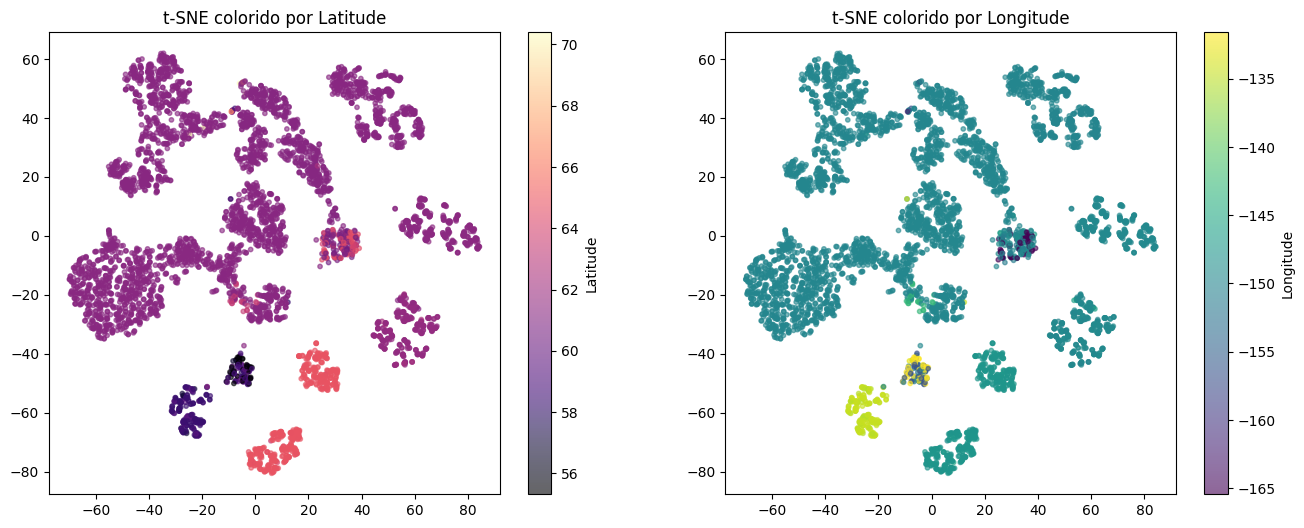

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

n_samples = 5000
indices = np.random.choice(len(loc_embeds), n_samples, replace=False)

subset_embeds = loc_embeds[indices]
subset_coords = coords[indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeds_2d = tsne.fit_transform(subset_embeds)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sc1 = ax[0].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 0], cmap='magma', s=10, alpha=0.6)
ax[0].set_title("t-SNE colorido por Latitude")
plt.colorbar(sc1, ax=ax[0], label='Latitude')

sc2 = ax[1].scatter(embeds_2d[:, 0], embeds_2d[:, 1],
                    c=subset_coords[:, 1], cmap='viridis', s=10, alpha=0.6)
ax[1].set_title("t-SNE colorido por Longitude")
plt.colorbar(sc2, ax=ax[1], label='Longitude')

plt.show()